Using TensorFlow backend.


(50000, 28, 28) (50000,)


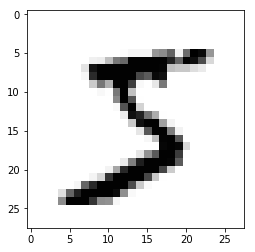

In [1]:
import sys
sys.path += ['week2']

from preprocessed_mnist import load_dataset
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset()
print(X_train.shape, y_train.shape)
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(X_train[0], cmap="Greys");

In [2]:
from scipy.misc import imrotate, imresize

In [3]:
import tensorflow as tf
import numpy as np

## Preparation

Relaunch tensorboard, and import useful libraries.

In [ ]:
! killall tensorboard
import os
os.system("tensorboard --logdir=/tmp/tboard --port=7007 &");

import tensorflow as tf

import numpy as np

# Data inspection and preparation

We first take a look at the data.

In [174]:
X_train.shape

(50000, 28, 28)

In [175]:
y_train[:10]

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4], dtype=uint8)

## Single layer neural network

We first create a simple single layer neural network. We use a one_hot encode layer and a reshape layer to create a flat X. This will prove to be troublesome in the future, but it works for the first version. We use a softmax function to compute the predicted classes.

Also, for debugging, we create the `correct_prediction` and `accuracy` nodes, to avoid having to compute these metrics by hand after running the network.

In [176]:
rows = 28
cols = 28
classes = 10

tf.reset_default_graph()
s = tf.InteractiveSession()

with tf.variable_scope("1nn"):
    weights = tf.get_variable("weights", 
                              [rows * cols, classes],
                              initializer=tf.random_normal_initializer(mean=0, stddev=1e-3),
                              dtype=tf.float32)
    b = tf.get_variable("bias", [classes],
                    initializer=tf.random_uniform_initializer(minval=0, maxval=1e-3),
                    dtype=tf.float32)

    input_X = tf.placeholder(tf.float32, shape=(None, rows, cols), name="input_X")
    input_y = tf.placeholder(tf.uint8, shape=(None,), name="input_Y")

    one_hot_y = tf.one_hot(input_y, classes)
    flat_X = tf.reshape(input_X, [-1, rows * cols])
    
    predicted_y = tf.nn.softmax(tf.matmul(flat_X, weights) + b)
    class_loss = -tf.log(predicted_y) * one_hot_y - tf.log(1 - predicted_y) * (1 - one_hot_y)
    loss = tf.reduce_mean(class_loss)
    
    correct_prediction = tf.equal(tf.cast(input_y, tf.int64), tf.argmax(predicted_y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

Let's test that the weights get correctly initialized.

In [178]:
s.run(tf.global_variables_initializer())
print(s.run([weights, b]))

[array([[  2.90627591e-04,  -8.48424563e-04,  -5.66490518e-04, ...,
         -4.51608095e-04,  -2.12985859e-03,  -1.60923937e-05],
       [ -6.81667647e-04,   5.14984014e-04,   1.52140157e-03, ...,
          5.55824779e-04,  -5.68696763e-04,   1.26391777e-03],
       [  6.70851208e-04,   5.27451106e-04,  -1.60427764e-03, ...,
          3.98793054e-04,  -1.00198283e-03,  -1.25634519e-03],
       ..., 
       [  1.29819789e-03,  -1.95469055e-03,   1.62665010e-03, ...,
         -1.92411919e-03,   4.05211176e-04,   1.04041095e-03],
       [  1.15162716e-03,  -2.66380655e-03,  -7.30710977e-04, ...,
          1.36331096e-03,  -7.79784285e-04,  -1.38115836e-03],
       [  1.13247125e-03,   4.03299666e-04,   8.59759690e-04, ...,
          3.93775845e-04,  -2.30012508e-03,   1.14530837e-03]], dtype=float32), array([  8.95980047e-04,   2.91217933e-04,   8.76299164e-05,
         3.24225199e-04,   6.80060999e-04,   9.89435590e-04,
         5.32781880e-04,   6.72814029e-04,   8.28988559e-05,
      

Let's test that the network computes different values correctly, or at least that they seem to be roughly correct. I struggled a bit with different data shapes and wrong initialization. I decided to keep this step to show what pains I went through.

In [179]:
s.run([weights, b, predicted_y, class_loss, one_hot_y, loss, correct_prediction, accuracy],
     {
         input_X: X_train[:3],
         input_y: y_train[:3]
     })

[array([[  2.90627591e-04,  -8.48424563e-04,  -5.66490518e-04, ...,
          -4.51608095e-04,  -2.12985859e-03,  -1.60923937e-05],
        [ -6.81667647e-04,   5.14984014e-04,   1.52140157e-03, ...,
           5.55824779e-04,  -5.68696763e-04,   1.26391777e-03],
        [  6.70851208e-04,   5.27451106e-04,  -1.60427764e-03, ...,
           3.98793054e-04,  -1.00198283e-03,  -1.25634519e-03],
        ..., 
        [  1.29819789e-03,  -1.95469055e-03,   1.62665010e-03, ...,
          -1.92411919e-03,   4.05211176e-04,   1.04041095e-03],
        [  1.15162716e-03,  -2.66380655e-03,  -7.30710977e-04, ...,
           1.36331096e-03,  -7.79784285e-04,  -1.38115836e-03],
        [  1.13247125e-03,   4.03299666e-04,   8.59759690e-04, ...,
           3.93775845e-04,  -2.30012508e-03,   1.14530837e-03]], dtype=float32),
 array([  8.95980047e-04,   2.91217933e-04,   8.76299164e-05,
          3.24225199e-04,   6.80060999e-04,   9.89435590e-04,
          5.32781880e-04,   6.72814029e-04,   8.28988

Finally, compute accuracy metrics when training the network. We train the network for 30 iterations, and log training and validation accuracy as we go along. Finally, we compute the final score using the test accuracy.

In [183]:
s.run(tf.global_variables_initializer())

losses = []
train_accuracies = []
validation_accuracies = []

for i in range(30):
    loss_i, accuracy_i, _ = s.run([loss, accuracy, optimizer], 
                                  {input_X: X_train, input_y: y_train})
    losses += [loss_i]
    train_accuracies += [accuracy_i]
    validation_accuracies += [s.run(accuracy, {input_X:X_val, input_y: y_val})]

test_accuracy = s.run(accuracy, {input_X:X_test, input_y: y_test})
print("Final test accuracy: {:.2f}".format(test_accuracy))

Final test accuracy: 0.80


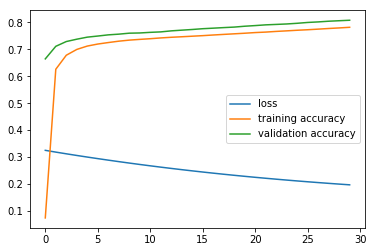

In [184]:
plt.figure()
plt.plot(losses);
plt.plot(train_accuracies)
plt.plot(validation_accuracies);
plt.legend(['loss', 'training accuracy', 'validation accuracy'])


As we can see, the network is not really good at all.

Next, we create a generator that will provide us with randomized minibatches, to do incremental training. The class takes an X and a y input array, and will provide shuffled batches until it covers the whole input, at which point it reshuffles the input again and provides more randomized batches.

In [185]:
import random

class MiniBatchGenerator:
    def __init__(self, X, y, batch_size):
        self.X = X.copy()
        self.y = y.copy()
        self.batch_size = batch_size
        self.current_i = 0
        self.total_size = len(self.X)
        
        self.reshuffle()
        
    def reshuffle(self):        
        idxs = list(range(self.total_size))
        random.shuffle(idxs)
        self.idxs = np.array(idxs, dtype=np.int32)
        
    def __iter__(self):
        return self
    
    def __next__(self):
        return self.next()
    
    def next(self):
        res_idxs = []
        
        end_i = self.current_i + self.batch_size
        
        if end_i > self.total_size:
            rem = end_i - self.total_size
            res_idxs = self.idxs[self.current_i:]
            self.reshuffle()
            res_idxs = np.append(res_idxs, self.idxs[:rem], axis=0)
            self.current_i = rem
        else:
            res_idxs = self.idxs[self.current_i:end_i]
            self.current_i = end_i

        return self.X[res_idxs], self.y[res_idxs]

The helper method train_network allows us to train a network and plot the training graphs, while varying iterations and batch_sizes. It's mostly here to save on typing.

In [189]:
def train_network(iterations=2000, batch_size=1000, X_train=X_train, y_train=y_train):
    s.run(tf.global_variables_initializer())

    batcher = MiniBatchGenerator(X_train, y_train, batch_size)

    losses = []
    batch_train_accuracies = []

    val_accuracies = []
    test_accuracies = []

    for i in range(iterations):
        X_batch, y_batch = batcher.next()

        loss_i, accuracy_i, optimizer_i = s.run([
            loss, accuracy, optimizer
        ],  {input_x: X_batch, 
                         label_y: y_batch})

        if i % 100 == 0:        
            losses += [loss_i]
            batch_train_accuracies += [accuracy_i]

            val_accuracy_i = s.run(
                accuracy 
            ,  {input_x: X_val, 
                 label_y: y_val})
            val_accuracies += [val_accuracy_i]

            test_accuracy_i = s.run(
                accuracy 
            ,  {input_x: X_test, 
                 label_y: y_test})
            test_accuracies += [test_accuracy_i]

            print("{} - loss: {}, train: {}, val: {}, test: {}".format(
                i, loss_i, accuracy_i, val_accuracy_i, test_accuracy_i))

    plt.figure()
    plt.plot(losses);
    plt.plot(batch_train_accuracies)
    plt.plot(val_accuracies)
    plt.plot(test_accuracies);
    plt.legend(['loss', 'batch train accuracy', 'validation accuracy', 'test accuracy'])

    l = len(batch_train_accuracies) - 20
    
    plt.figure()
    plt.plot(batch_train_accuracies[-l:])
    plt.plot(test_accuracies[-l:]);
    plt.legend(['batch training accuracy', 'test accuracy'])

## Multilayer neural network

In this neural network, we use a second 50 neuron layer. The first layer has a sigmoid activation function.

In [190]:
from preprocessed_mnist import load_dataset
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset()
print(X_train.shape, y_train.shape)

import tensorflow as tf

rows = 28
cols = 28
classes = 10

layer_cnt = 0

def add_layer(in_, size, output_f, sigma=1):
    global layer_cnt
    
    W2 = tf.get_variable("weights{}".format(layer_cnt),
                         [in_.shape[1], size],
                         initializer=tf.random_normal_initializer(mean=0, stddev=sigma),
                         dtype=tf.float32)
    b2 = tf.get_variable("bias{}".format(layer_cnt),
                         [size],
                         initializer=tf.zeros_initializer(),
                         dtype=tf.float32)

    y2 = output_f(tf.matmul(in_, W2) + b2)
    
    layer_cnt += 1
    return y2

hidden_size = 30

tf.reset_default_graph()
s = tf.InteractiveSession()

with tf.variable_scope("1nn-2layers"):
    # input shape
    input_x = tf.placeholder(tf.float32, shape=(None, rows, cols), name="input_X")
    label_y = tf.placeholder(tf.uint8, shape=(None,), name="input_Y")

    y_ = tf.one_hot(label_y, classes, dtype=tf.float32)
    x = tf.reshape(input_x, [-1, rows * cols])
    
    sigma = 1

    # input layer
    y1 = add_layer(x, 50, tf.nn.sigmoid, sigma=sigma)
    # output layer
    y = add_layer(y1, 10, tf.nn.softmax, sigma=sigma)

    loss = tf.reduce_mean(-tf.reduce_sum(tf.cast(y_, tf.float32) * tf.log(y), 
    reduction_indices=[1]))
    
    correct_prediction = tf.equal(tf.argmax(y_, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    optimizer = tf.train.GradientDescentOptimizer(2.).minimize(loss)
    
    s.run(tf.global_variables_initializer())



(50000, 28, 28) (50000,)


0 - loss: 7.090571403503418, train: 0.07499999552965164, val: 0.15569999814033508, test: 0.15950000286102295
100 - loss: 0.5709184408187866, train: 0.8109999895095825, val: 0.8253999948501587, test: 0.8206000328063965
200 - loss: 0.4420139193534851, train: 0.8650000095367432, val: 0.8673000335693359, test: 0.8622000217437744
300 - loss: 0.39291051030158997, train: 0.8849999904632568, val: 0.884600043296814, test: 0.8803000450134277
400 - loss: 0.3692992627620697, train: 0.8959999680519104, val: 0.8942001461982727, test: 0.8925000429153442
500 - loss: 0.3438720107078552, train: 0.8949999809265137, val: 0.900700032711029, test: 0.8999000787734985
600 - loss: 0.3218311667442322, train: 0.9120000004768372, val: 0.9080000519752502, test: 0.9070000648498535
700 - loss: 0.300199031829834, train: 0.9129999876022339, val: 0.9117000102996826, test: 0.9107001423835754
800 - loss: 0.321649968624115, train: 0.9000000953674316, val: 0.9158002138137817, test: 0.9157000780105591
900 - loss: 0.28430581

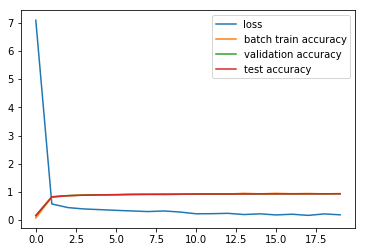

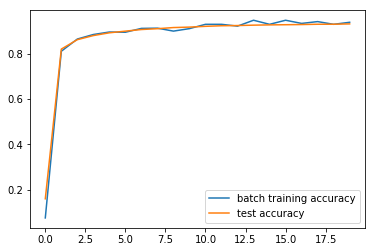

In [191]:
train_network()

As we can see, this network is already much better, but it still is not better than logistic regression. We can train for longer, add more layers, tweak the learning rate and the batch sizes, which I have done in excruciating detail. However, I will only provide the final solution. What I did was expand the training set by rotating images back and forth, and resizing them. This allows us to have way more training data, which is quite beneficial. So in this segment, we generate an `expanded_X_train` that has rotate and scaled images. This takes quite a while to run because I haven't tried to remotely optimize it.

In [192]:
expanded_X_train = []
expanded_y_train = []

def img_resize(img, percent):
    img_ = imresize(img, percent)
    offset = int((img_.shape[0] - 28) / 2)
    return img_[offset:offset+28, offset:offset+28]

for i in range(len(X_train)):
    img = X_train[i]
    img_class = y_train[i]

    expanded_X_train += [img]
    expanded_y_train += [img_class]

    for angle in [5, -5, 10, -10, -15, 15, -20, 20]:
#     for angle in [10, -10]:
        img_ = imrotate(img, angle) / 255.
        assert img_.shape[0] == 28
        expanded_X_train += [img_]
        expanded_y_train += [img_class]
    
    for scale in [120, 110]:
        img_ = img_resize(img, scale) / 255.
        assert img_.shape[0] == 28
        expanded_X_train += [img_]
        expanded_y_train += [img_class]
    
expanded_X_train = np.array(expanded_X_train)
expanded_y_train = np.array(expanded_y_train)


Here is the transformed versions of the first digit:

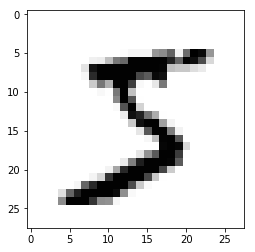

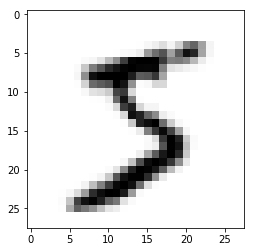

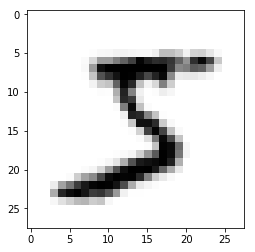

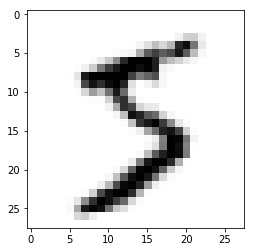

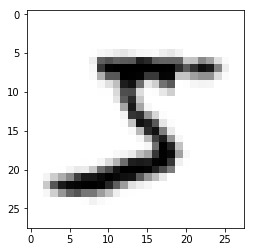

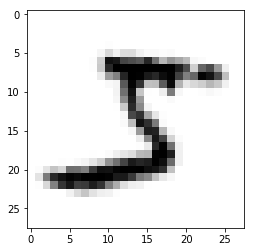

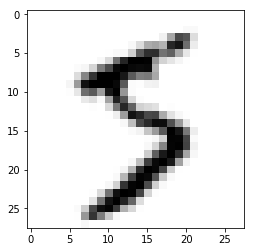

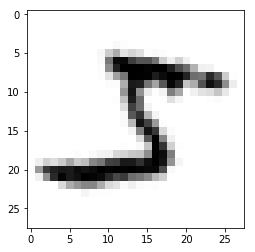

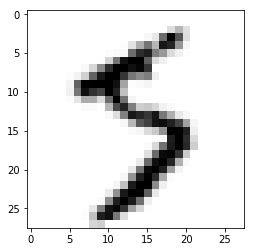

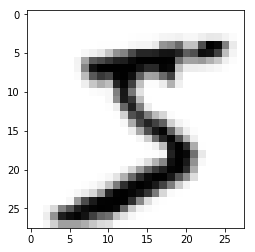

In [193]:
for i in range(10):
    plt.figure()
    plt.imshow(expanded_X_train[i], cmap="Greys");

Finally, we use fairly simple 3 layer neural network. An important change I did was to add a L2 loss to every layer, so that we avoid overfitting on the training set. I played around with different metrics and initialization standard deviation and learning rate, but this setup seems to reliably achieve a stable 98% accuracy, so that's what I'm submitting.

In [194]:
tf.reset_default_graph()
s = tf.InteractiveSession()

def add_layer_with_loss(in_, size, output_f, sigma=1):
    global layer_cnt
    
    W2 = tf.get_variable("weights{}".format(layer_cnt),
                         [in_.shape[1], size],
                         initializer=tf.random_normal_initializer(mean=0, stddev=sigma),
                         dtype=tf.float32)
    b2 = tf.get_variable("bias{}".format(layer_cnt),
                         [size],
                         initializer=tf.zeros_initializer(),
                         dtype=tf.float32)

    y2 = output_f(tf.matmul(in_, W2) + b2)
    
    loss = tf.norm(W2, ord=2)
#     loss = tf.reduce_sum(tf.sqrt(tf.tensordot(tf.squeeze(W2), tf.squeeze(W2), 1)))
#     loss += tf.reduce_sum(tf.sqrt(tf.tensordot(b2, b2, 1)))
    
    layer_cnt += 1
    return y2, loss


with tf.variable_scope("1nn-2layers"):
    # input shape
    input_x = tf.placeholder(tf.float32, shape=(None, rows, cols), name="input_X")
    label_y = tf.placeholder(tf.uint8, shape=(None,), name="input_Y")

    y_ = tf.one_hot(label_y, classes, dtype=tf.float32)
    x = tf.reshape(input_x, [-1, rows * cols])
    
    sigma = np.sqrt(2. / 10.)
    sigma = .1
    print("sigma", sigma)
  
    # input layer
    loss_lambda = 0.005
    
    y1, loss_ = add_layer_with_loss(x, 100, tf.nn.relu, sigma=sigma)
    loss = loss_lambda * loss_
    y3, loss_ = add_layer_with_loss(y1, 50, tf.nn.relu, sigma=sigma)
    loss += loss_lambda * loss_
    y, loss_ = add_layer_with_loss(y3, 10, tf.nn.softmax, sigma=sigma)
    loss += loss_lambda * loss_

    loss += tf.reduce_mean(-tf.reduce_sum(tf.cast(y_, tf.float32) * tf.log(y), 
    reduction_indices=[1]))
    
    correct_prediction = tf.equal(tf.argmax(y_, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    global_step = tf.Variable(0, trainable=False)
    starter_learning_rate = .8
    learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,
                                           100, 0.96, staircase=True)

#     optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
    optimizer = tf.train.GradientDescentOptimizer(.2).minimize(loss)

    
    s.run(tf.global_variables_initializer())

# train_network(iterations=5000, batch_size=1000, X_train=X_train, y_train=y_train)

sigma 0.1


Training the network for 20000 iterations on a batch size of 100, which takes about 30 seconds on my computer, gives us a reliably and not overfitted 98% accuracy.

0 - loss: 2.556960344314575, train: 0.09999999403953552, val: 0.10780000686645508, test: 0.1143999919295311
100 - loss: 1.1932165622711182, train: 0.6499999761581421, val: 0.7937000393867493, test: 0.7897999882698059
200 - loss: 0.5771803855895996, train: 0.8399999141693115, val: 0.9047001600265503, test: 0.9031000733375549
300 - loss: 0.5571106672286987, train: 0.8799999952316284, val: 0.9215000867843628, test: 0.9206001162528992
400 - loss: 0.4599230885505676, train: 0.9200000762939453, val: 0.9350000619888306, test: 0.9318000674247742
500 - loss: 0.5097686648368835, train: 0.89000004529953, val: 0.9222001433372498, test: 0.9164000749588013
600 - loss: 0.4417042136192322, train: 0.9300000667572021, val: 0.9431000351905823, test: 0.938500165939331
700 - loss: 0.43639278411865234, train: 0.9100000262260437, val: 0.9490001797676086, test: 0.9451001286506653
800 - loss: 0.5587894916534424, train: 0.9000000357627869, val: 0.9492001533508301, test: 0.9436001181602478
900 - loss: 0.46789586

7500 - loss: 0.29827746748924255, train: 0.949999988079071, val: 0.9758001565933228, test: 0.9768002033233643
7600 - loss: 0.24681855738162994, train: 0.9900000095367432, val: 0.9787001013755798, test: 0.9769001603126526
7700 - loss: 0.2628343105316162, train: 0.9799999594688416, val: 0.9774000644683838, test: 0.9785001277923584
7800 - loss: 0.2622239589691162, train: 0.9799999594688416, val: 0.9751001596450806, test: 0.9764000773429871
7900 - loss: 0.28552430868148804, train: 0.9800000190734863, val: 0.9790001511573792, test: 0.9807001352310181
8000 - loss: 0.23918846249580383, train: 0.9800000190734863, val: 0.9785001277923584, test: 0.9788001775741577
8100 - loss: 0.30482417345046997, train: 0.9699999690055847, val: 0.9780001640319824, test: 0.9798001050949097
8200 - loss: 0.2568243443965912, train: 0.9800000190734863, val: 0.9767000675201416, test: 0.9793002009391785
8300 - loss: 0.29105350375175476, train: 0.9600000381469727, val: 0.9785001277923584, test: 0.9799001216888428
8400 

14900 - loss: 0.21658194065093994, train: 0.9899999499320984, val: 0.9797001481056213, test: 0.9827001690864563
15000 - loss: 0.22431758046150208, train: 0.9900000095367432, val: 0.9775000810623169, test: 0.9769001007080078
15100 - loss: 0.2114977240562439, train: 0.9899999499320984, val: 0.9804001450538635, test: 0.9803001284599304
15200 - loss: 0.21212759613990784, train: 0.9999999403953552, val: 0.9821001291275024, test: 0.9817001819610596
15300 - loss: 0.2654315233230591, train: 0.9600000381469727, val: 0.9803001284599304, test: 0.9818000793457031
15400 - loss: 0.25795844197273254, train: 0.9600000381469727, val: 0.9809001088142395, test: 0.9814001321792603
15500 - loss: 0.23423829674720764, train: 0.9899999499320984, val: 0.980800211429596, test: 0.9816001057624817
15600 - loss: 0.21903783082962036, train: 0.9900000095367432, val: 0.9814001321792603, test: 0.9821001887321472
15700 - loss: 0.2543771266937256, train: 0.9600000381469727, val: 0.9806001782417297, test: 0.9824001193046

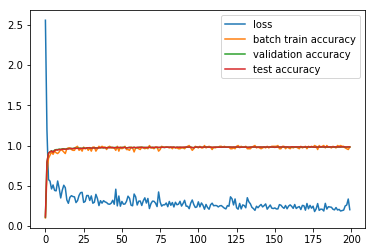

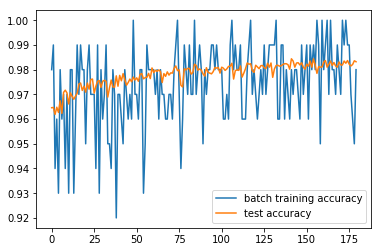

In [196]:
train_network(iterations=20000, batch_size=100, X_train=expanded_X_train, y_train=expanded_y_train)